### well structured - an ode to databases


In [35]:
# access libaries
import yfinance as yf
import sqlite3

# scientific computing pandas (data structures & tools), NumPy (array & tools), SciPy (Integrals, solving differential equations, optimization)
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


# Visualization matplotlib (plots & graphs, most popular), seaborn (plots: heat maps, time series, violin plots)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [36]:
class stock_eval:
    def __init__(self, ticker_symbol):

        # load data
        self.ticker_symbol = ticker_symbol
        self.company_name = yf.Ticker(self.ticker_symbol).info['longName'].replace(r'/', ' ')
        self.currency = yf.Ticker(self.ticker_symbol).info['currency']

        self.to_sql_stock_prices = []

# ------------------------ DATABASE -----------------------------------------

    def to_sqlite_database(self, db_name):

        conn = sqlite3.connect(db_name)
        self.to_sql_stock_prices.to_sql(name=self.company_name, con=conn, if_exists='replace')
        conn.commit()
        conn.close() 

    def read_sqlite_database(self, ticker_symbol, db_name, columns):
               
        company_name = yf.Ticker(ticker_symbol).info['longName'].replace(r'/', ' ')
        conn = sqlite3.connect(db_name)
        sql = "SELECT " + columns + " FROM `" + company_name + "`"
        result = pd.read_sql(sql,conn)
        return result

In [37]:
ticker_symbols = ['WOOE.AS', 'WY', 'SCA-B.ST', 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH']
bucket_stock_prices = pd.DataFrame()

for ticker_symbol in ticker_symbols:
    
    # load first item
    stock_mode_obj = stock_eval(ticker_symbol)
    columns = '`close_normal_' + ticker_symbol + '`'
    bucket_stock_prices_load = stock_mode_obj.read_sqlite_database(stock_mode_obj.ticker_symbol, 'stocks_prep.db', columns)

    # concat data
    bucket_stock_prices = pd.concat([bucket_stock_prices, bucket_stock_prices_load], axis=1)

bucket_stock_prices.head(2)

,close_normal_WOOE.AS,close_normal_WY,close_normal_SCA-B.ST,close_normal_SUZ,close_normal_SK3.IR,close_normal_IP,close_normal_STERV.HE,close_normal_RYN,close_normal_WFG,close_normal_WRK,close_normal_PCH
0,0.780673,0.797964,0.644627,0.635598,0.896732,0.901814,0.684542,0.779544,0.695476,0.810607,0.846914
1,0.777786,0.777169,0.627652,0.628880,0.884664,0.895734,0.673074,0.770119,0.694028,0.796625,0.833761


# simple linear regression

### all values

In [38]:
# load data
sim_lin_reg_dep_var = pd.DataFrame(bucket_stock_prices['close_normal_WOOE.AS'])
sim_lin_reg_indep_var = pd.DataFrame(bucket_stock_prices['close_normal_WY'])

bucket_sim_lin_reg = pd.concat([sim_lin_reg_dep_var, sim_lin_reg_indep_var], axis=1)

# load model
sim_lin_reg_obj = LinearRegression()

# fit model
sim_lin_reg_obj.fit(sim_lin_reg_dep_var,sim_lin_reg_indep_var)

# predict model
bucket_sim_lin_reg_load = sim_lin_reg_obj.predict(sim_lin_reg_dep_var)

# transform and rename df
bucket_sim_lin_reg_load = map(lambda x: x[0], bucket_sim_lin_reg_load)
bucket_sim_lin_reg_load = pd.Series(bucket_sim_lin_reg_load)
bucket_sim_lin_reg_load = bucket_sim_lin_reg_load.rename('sim_lin_reg_WY')

# concat df
bucket_sim_lin_reg_pred = pd.concat([sim_lin_reg_dep_var, bucket_sim_lin_reg_load], axis=1)

### training values

In [39]:
x_train_sim_lin_reg, x_test_sim_lin_reg, y_train_sim_lin_reg, y_test_sim_lin_reg = train_test_split(sim_lin_reg_indep_var, sim_lin_reg_dep_var, test_size=0.10, random_state=1)

# load data
train_sim_lin_reg_dep_var = y_train_sim_lin_reg
train_sim_lin_reg_indep_var = x_train_sim_lin_reg.rename(columns={'close_normal_WY':'train_close_normal_WY'})

train_bucket_sim_lin_reg = pd.concat([train_sim_lin_reg_dep_var, train_sim_lin_reg_indep_var], axis=1)

# load model
train_sim_lin_reg_obj = LinearRegression()

# fit model
train_sim_lin_reg_obj.fit(train_sim_lin_reg_dep_var,train_sim_lin_reg_indep_var)

# predict model
train_bucket_sim_lin_reg_load = train_sim_lin_reg_obj.predict(train_sim_lin_reg_dep_var)

# transform and rename df
train_bucket_sim_lin_reg_load = map(lambda x: x[0], train_bucket_sim_lin_reg_load)
train_bucket_sim_lin_reg_load = pd.Series(train_bucket_sim_lin_reg_load)
train_bucket_sim_lin_reg_load = train_bucket_sim_lin_reg_load.rename('train_sim_lin_reg_WY')



# concat df
train_bucket_sim_lin_reg_pred = pd.concat([train_sim_lin_reg_dep_var, train_bucket_sim_lin_reg_load], axis=1)

print("number of test samples :", x_test_sim_lin_reg.shape[0])
print("number of training samples:",x_train_sim_lin_reg.shape[0])

number of test samples : 63
number of training samples: 561


### test values

In [40]:
x_train_sim_lin_reg, x_test_sim_lin_reg, y_train_sim_lin_reg, y_test_sim_lin_reg = train_test_split(sim_lin_reg_indep_var, sim_lin_reg_dep_var, test_size=0.10, random_state=1)

# load data
test_sim_lin_reg_dep_var = y_test_sim_lin_reg
test_sim_lin_reg_indep_var = x_test_sim_lin_reg.rename(columns={'close_normal_WY':'test_close_normal_WY'})

test_bucket_sim_lin_reg = pd.concat([test_sim_lin_reg_dep_var, test_sim_lin_reg_indep_var], axis=1)

# load model
test_sim_lin_reg_obj = LinearRegression()

# fit model
test_sim_lin_reg_obj.fit(test_sim_lin_reg_dep_var,test_sim_lin_reg_indep_var)

# predict model
test_bucket_sim_lin_reg_load = test_sim_lin_reg_obj.predict(test_sim_lin_reg_dep_var)

# transform and rename df
test_bucket_sim_lin_reg_load = map(lambda x: x[0], test_bucket_sim_lin_reg_load)
test_bucket_sim_lin_reg_load = pd.Series(test_bucket_sim_lin_reg_load)
test_bucket_sim_lin_reg_load = test_bucket_sim_lin_reg_load.rename('test_sim_lin_reg_WY')

# concat df
test_bucket_sim_lin_reg_pred = pd.concat([test_sim_lin_reg_dep_var, test_bucket_sim_lin_reg_load], axis=1)

print("number of test samples :", x_test_sim_lin_reg.shape[0])
print("number of training samples:",x_train_sim_lin_reg.shape[0])

number of test samples : 63
number of training samples: 561


#### regression plot

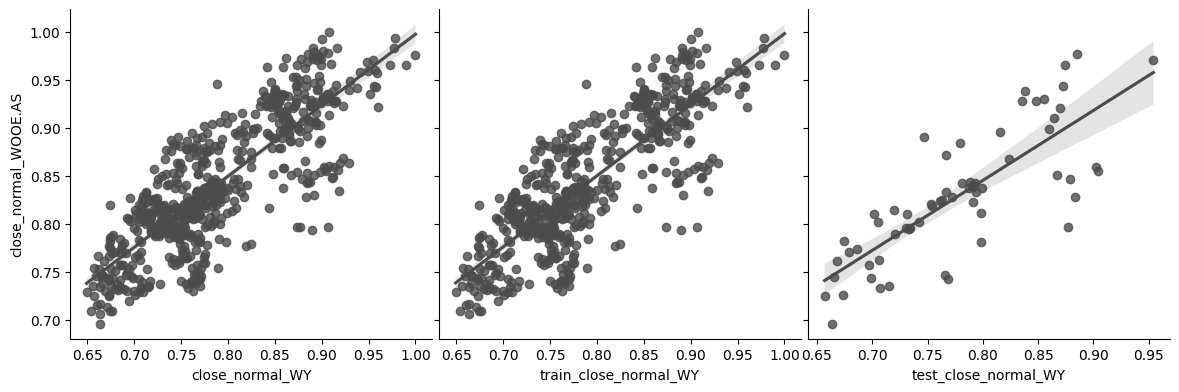

In [41]:
plot_bucket_sim_lin_reg = pd.concat([bucket_sim_lin_reg, train_sim_lin_reg_indep_var, test_sim_lin_reg_indep_var], axis=1)

g = sns.PairGrid(plot_bucket_sim_lin_reg, y_vars=["close_normal_WOOE.AS"], x_vars=["close_normal_WY", 'train_close_normal_WY','test_close_normal_WY'], height=4)
g.map(sns.regplot, color=".3")
g.figure.subplots_adjust(wspace=.02, hspace=.02)

#### residual plot

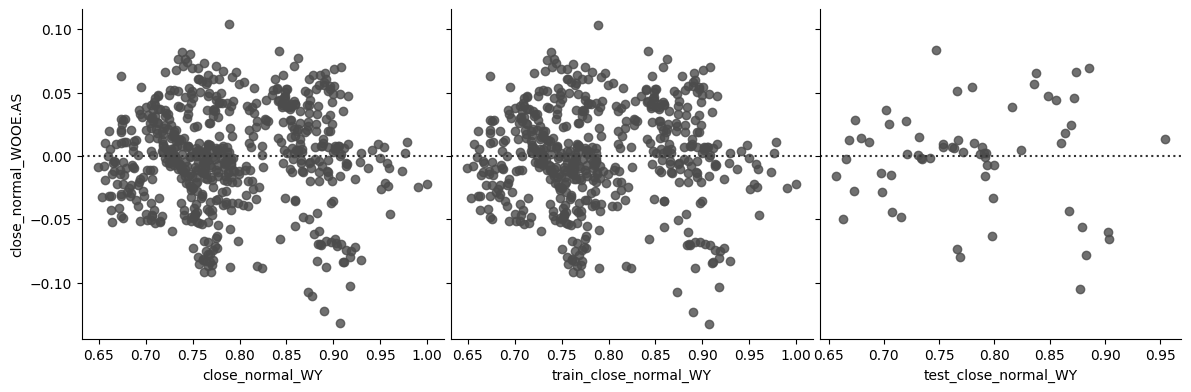

In [42]:
plot_bucket_sim_lin_reg = pd.concat([bucket_sim_lin_reg, train_sim_lin_reg_indep_var, test_sim_lin_reg_indep_var], axis=1)

g = sns.PairGrid(plot_bucket_sim_lin_reg, y_vars=["close_normal_WOOE.AS"], x_vars=["close_normal_WY", 'train_close_normal_WY','test_close_normal_WY'], height=4)
g.map(sns.residplot, color=".3")
g.figure.subplots_adjust(wspace=.02, hspace=.02)

#### distribution plot

<Figure size 600x500 with 0 Axes>

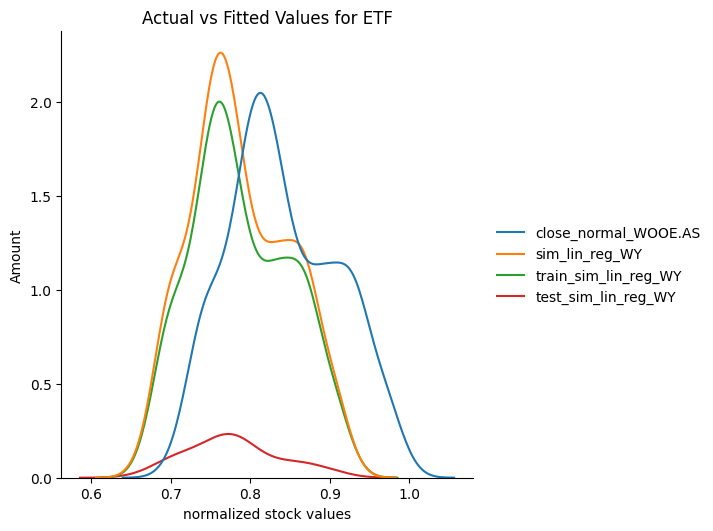

In [43]:
plot_bucket_sim_lin_reg_pred = pd.concat([bucket_sim_lin_reg_pred,train_bucket_sim_lin_reg_load, test_bucket_sim_lin_reg_load], axis=1)
plt.figure(figsize=(6, 5))
sns.displot(plot_bucket_sim_lin_reg_pred, label="Fitted Values" , kind="kde")
plt.title('Actual vs Fitted Values for ETF')
plt.xlabel('normalized stock values')
plt.ylabel('Amount')
plt.show()
plt.close()


### cross validation score

In [44]:
Rcross = cross_val_score(train_sim_lin_reg_obj, train_sim_lin_reg_indep_var, train_sim_lin_reg_dep_var, cv=4)
Rcross

array([0.63626041, 0.70735738, 0.64317909, 0.68713339])

In [45]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.6684825644611874 and the standard deviation is 0.029739020933747105


In [46]:
-1 * cross_val_score(train_sim_lin_reg_obj, train_sim_lin_reg_indep_var, train_sim_lin_reg_dep_var, cv=4,scoring='neg_mean_squared_error')

array([0.00154651, 0.00149853, 0.00162573, 0.00141948])

In [47]:
yhat = cross_val_predict(train_sim_lin_reg_obj, train_sim_lin_reg_indep_var, train_sim_lin_reg_dep_var, cv=4)
yhat[0:5]

array([[0.8312098 ],
       [0.81791882],
       [0.80987125],
       [0.89389774],
       [0.81520745]])

# multiple regresion plot

### all values

In [48]:
# load data
mult_lin_reg_dep_var = bucket_stock_prices['close_normal_WOOE.AS']
mult_lin_reg_indep_var = bucket_stock_prices[["close_normal_WY", 'close_normal_IP', 'close_normal_WRK']]

#bucket_mul_lin_reg = pd.concat([mult_lin_reg_dep_var, mult_lin_reg_indep_var], axis=1)

# load model
multi_lin_reg_obj = LinearRegression()

# fit model
multi_lin_reg_obj.fit(mult_lin_reg_indep_var, mult_lin_reg_dep_var)

# predict model
bucket_mul_lin_reg_load=multi_lin_reg_obj.predict(mult_lin_reg_indep_var)

# transform and rename df
#bucket_mul_lin_reg_load = map(lambda x: x[0], bucket_mul_lin_reg_load)
bucket_mul_lin_reg_load = pd.Series(bucket_mul_lin_reg_load)
bucket_mul_lin_reg_load = bucket_mul_lin_reg_load.rename('sim_lin_reg')

# concat df
bucket_sim_lin_reg_pred = pd.concat([sim_lin_reg_dep_var, bucket_mul_lin_reg_load], axis=1)


### training_values

### test_data

<Figure size 600x500 with 0 Axes>

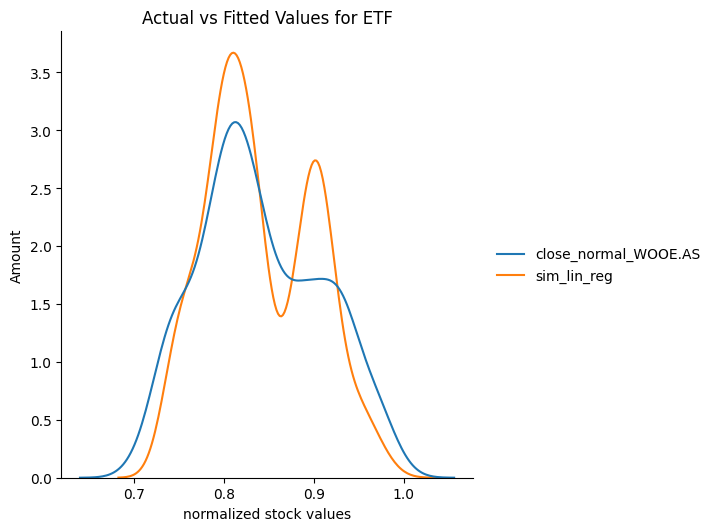

In [49]:
plt.figure(figsize=(6, 5))
sns.displot(bucket_sim_lin_reg_pred, label="Fitted Values" , kind="kde")
plt.title('Actual vs Fitted Values for ETF')
plt.xlabel('normalized stock values')
plt.ylabel('Amount')
plt.show()
plt.close()

# polinominal plot

### overfitting

### ridge regression

### grid search